## Natural Language Processing with Disaster Tweets

### Introduction

- The purpose of this notebook is to evaluate the provided Tweeter data and develop a NLP model to predict which Tweets are referring to real disasters.
- I will leverage the starter notebook provided, which uses the DistilBERT model, and will add data cleaning steps to try to improve on the starter notebook results

### Imports

- Library Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk

# download nltk stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split

from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



Using TensorFlow backend


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuelportillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Import Data

In [2]:
path = '/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/module4/kaggle_nlp_data/nlp-getting-started'

train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')
sample_df = pd.read_csv(f'{path}/sample_submission.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# summarize the training data
def summary_info(df):
    print("INFO")
    display(df.info());
    print('\n')
    print("Summary information")
    display(df.describe())
    print('\n')
    print("Null Values")
    null_values = df.isnull().sum()/df.shape[0]
    display(null_values[null_values >0])
    print('\n')
    print('Duplicate Articles')
    display(df.duplicated().sum())

summary_info(train_df)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None



Summary information


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000




Null Values


keyword     0.008013
location    0.332720
dtype: float64



Duplicate Articles


np.int64(0)

### EDA

- Train data distribution

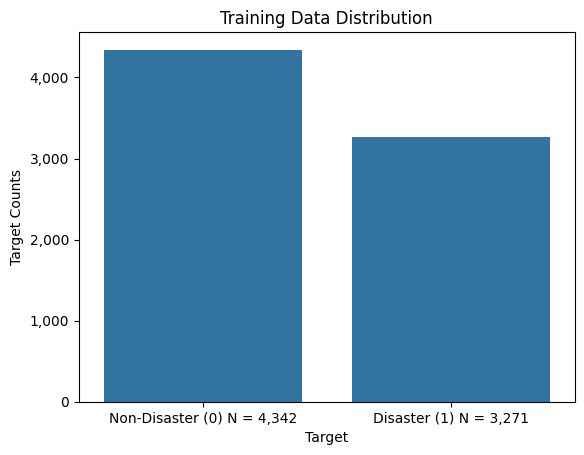

In [4]:
order_values = train_df['target'].value_counts().index
ax = sns.countplot(train_df, x='target', order = order_values)
plt.xlabel('Target')
plt.ylabel('Target Counts')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Training Data Distribution')
plt.xticks(ticks=[0, 1], labels=[f"Non-Disaster (0) N = {train_df['target'].value_counts()[0]:,}", 
                                 f"Disaster (1) N = {train_df['target'].value_counts()[1]:,}"]); 

- Distribution of word and character counts 

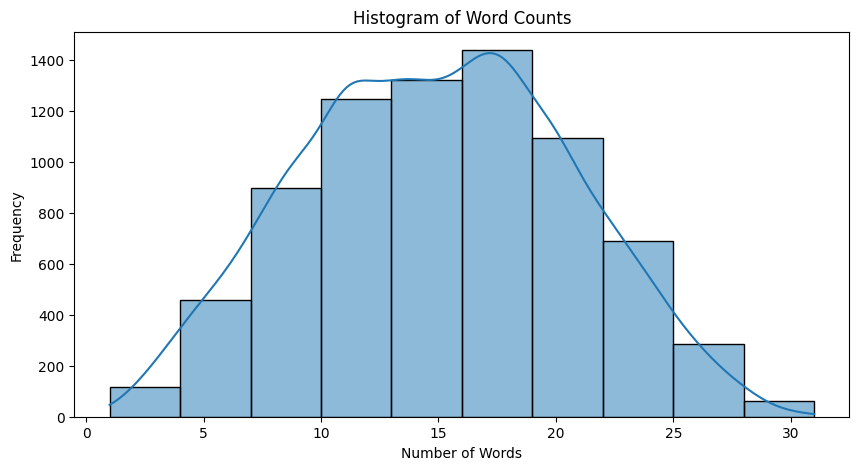

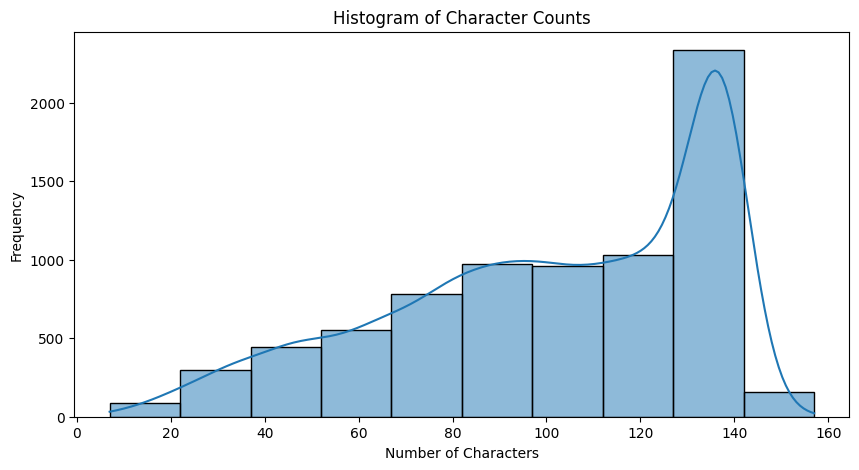

In [5]:
# check word count in text
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))

#Histogram of word counts
plt.figure(figsize = (10,5));
sns.histplot(train_df['word_count'],bins = 10,kde = True);
plt.title('Histogram of Word Counts');
plt.xlabel('Number of Words');
plt.ylabel('Frequency');


#Histogram of Character Counts
plt.figure(figsize = (10,5));
sns.histplot(train_df['char_count'], bins = 10,kde = True);
plt.title('Histogram of Character Counts');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');


In [6]:
#Average and mean lengths per category
length_stats = train_df.groupby('target').agg(
    avg_words = ('word_count', 'mean'),
    median_words = ("word_count", 'median'),
    avg_chars = ('char_count', 'mean'),
    median_chars = ('char_count', 'median')
).round(2)

length_stats

,avg_words,median_words,avg_chars,median_chars
target,,,,
0,14.70,15.0,95.71,101.0
1,15.17,15.0,108.11,115.0


- The summary shows that disaster tweets are slightly longer than the non-disaster tweets

- Most common words in tweets

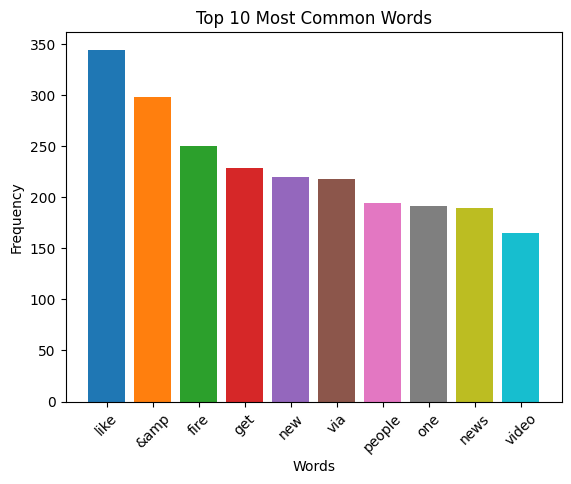

In [7]:
stop_words = set(stopwords.words('english'))

# function to tokenize and remove stopwords
def tokenize_text(text):
    words = str(text).lower().split()
    words = [w.strip('.,!?;:()[]-"\'%#') for w in words]
    return [w for w in words  if w not in stop_words and w != '']
    
# Most common words 
all_words = []
train_df['text'].apply(lambda x: all_words.extend(tokenize_text(x)))
overall_counts = Counter(all_words)
top10_words = dict(overall_counts.most_common(10))
for word, count in top10_words.items():
    plt.bar(word,count)
    plt.title("Top 10 Most Common Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45);


- Most common words in non-disaster (0) vs. disaster (1) tweets

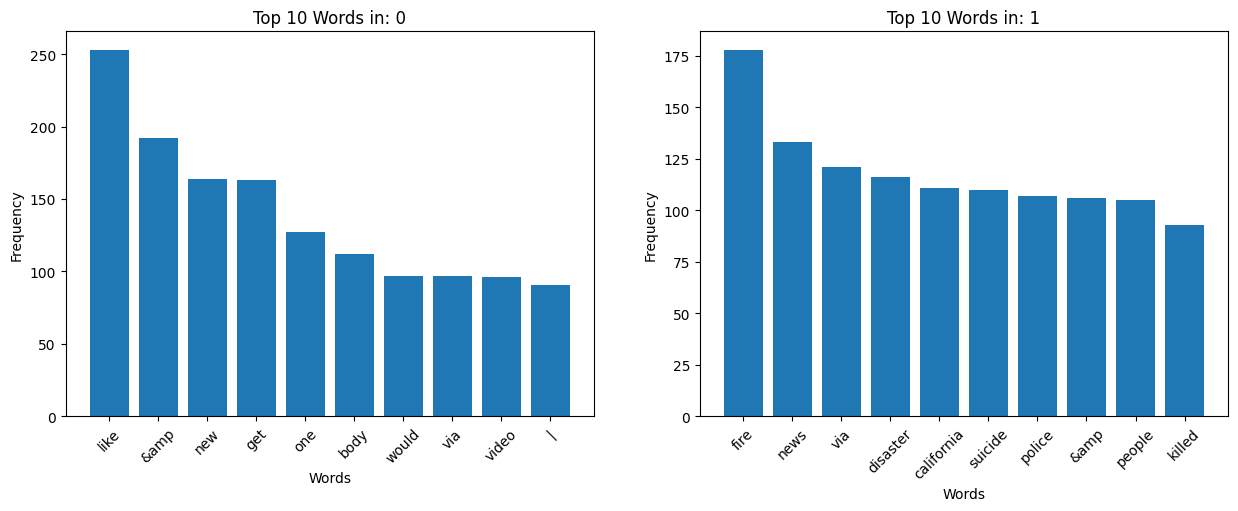

In [8]:
# Most common words and Vocabulary per category
vocab_per_category = {}
category_counts = {}
for cat, group in train_df.groupby('target'):
    words_cat = []
    group['text'].apply(lambda x: words_cat.extend(tokenize_text(x)))
    category_counts[cat] = Counter(words_cat).most_common(10)
    vocab_per_category[cat] = len(set(words_cat))
    
vocab = pd.DataFrame({
    'Cetegory': list(vocab_per_category.keys()),
    'Vocabary_size': list(vocab_per_category.values())
})


fig, axes = plt.subplots(1,2,figsize = (15, 5))
axes = axes.flatten()

for ax, (cat, counts) in zip(axes, category_counts.items()):
    words,freq = zip(*counts)
    ax.bar(words, freq)
    ax.set_title(f'Top 10 Words in: {cat}')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis = 'x', rotation = 45)


##### Fire and suicide appear to be the largest reason for disasters in these tweets - with a lot of these happening in California, likely mostly due to fires

In [9]:
# look at size of vocabulary used in types of tweets
vocab

,Cetegory,Vocabary_size
0,0,14900
1,1,12043


- The higher number indicates a larger vocabulary or a more diverse word usage. For disaster tweets, a smaller vocabulary and higher word count indicates repeat use of words.

### Topic Modeling  

- Train/Test split and Validation data 

In [23]:
X = train_df['text']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
X_test = test_df['text']

- Will use topic modeling TF-IDF + Single Value Decomposition + Logistic Regression

In [24]:
# specify model pipeline and find best parameters to use
Pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(random_state=42),
    LogisticRegression(max_iter=2000, random_state=42)
)

param_distributions = {
    'tfidfvectorizer__max_features': [5000, 10000, 15000],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__min_df': [2, 3, 5],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.95],
    'truncatedsvd__n_components': [100, 150, 200],
    'logisticregression__C': uniform(0.1, 10),
}

Random_search = RandomizedSearchCV(
    Pipeline,
    param_distributions=param_distributions,
    n_iter=20,          # number of random combinations to try
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=0,
    n_jobs=-1,
    random_state=42
)

Random_search.fit(train_df['text'], train_df['target'])
best_params = Random_search.best_params_
print("Best parameters:", best_params)
print("Best CV accuracy:", Random_search.best_score_)


/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/c312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'logisticregression__C': np.float64(2.40893825622149), 'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__max_features': 15000, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 2), 'truncatedsvd__n_components': 200}
Best CV accuracy: 0.7082696938661937


In [25]:
# function to display confusion matrix 
def display_report(model):
    pred = model.predict(train_df['text'])
    print(classification_report(train_df['target'].astype(str), pred))
    cm = confusion_matrix(train_df['target'].astype(str),  pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=train_df['target'].astype(str).unique())
    disp.plot(xticks_rotation=45,cmap='Blues')
    plt.show()

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      4342
           1       0.81      0.65      0.72      3271

    accuracy                           0.78      7613
   macro avg       0.79      0.77      0.77      7613
weighted avg       0.79      0.78      0.78      7613



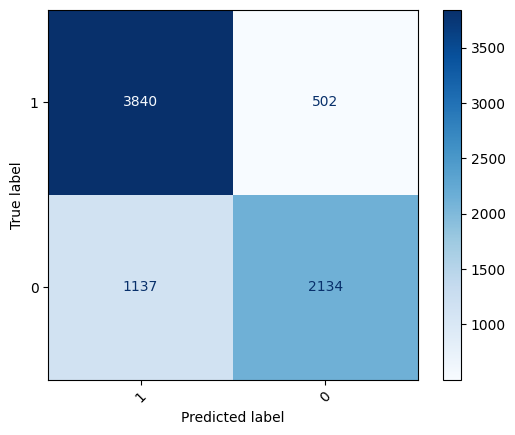

In [26]:
# results from using the best parameters found
Pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words='english',
        max_features=best_params['tfidfvectorizer__max_features'],
        ngram_range=best_params['tfidfvectorizer__ngram_range'],
        min_df=best_params['tfidfvectorizer__min_df'],
        max_df=best_params['tfidfvectorizer__max_df']
    ),
    TruncatedSVD(
        n_components=best_params['truncatedsvd__n_components'],
        random_state=42
    ),
    LogisticRegression(
        max_iter=2000,
        C=best_params['logisticregression__C'],
        random_state=42
    )
)

Pipeline.fit(train_df['text'], train_df['target'].astype(str))
display_report(Pipeline)

In [20]:
model = Pipeline.fit(train_df['text'], train_df['target'].astype(str))

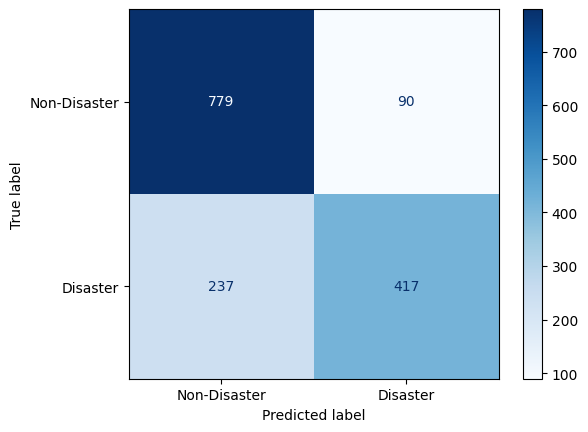

In [30]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

disp = ConfusionMatrixDisplay.from_predictions(y_val.astype(str)
                                               ,y_pred_val
                                               ,display_labels=["Non-Disaster", "Disaster"]
                                               ,cmap=plt.cm.Blues
                                               )

In [33]:
tn, fp, fn, tp = confusion_matrix(y_val.astype(str), y_pred_val).ravel()
f1_score = tp / (tp+((fn+fp)/2))
f1_score

np.float64(0.7183462532299741)

In [11]:
# clean the original text before tokenizing for DistilBERT modeling
train_df['text_c'] = train_df['text'].apply(lambda x: tokenize_text(x)) 
train_df['text_f'] = train_df['text_c'].apply(lambda x: ' '.join(x))

test_df['text_c'] = test_df['text'].apply(lambda x: tokenize_text(x)) 
test_df['text_f'] = test_df['text_c'].apply(lambda x: ' '.join(x))

display(train_df.head())
display(test_df.head())

,id,keyword,location,text,target,word_count,char_count,text_c,text_f
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,"[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,"[residents, asked, shelter, place, notified, o...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,"[13,000, people, receive, wildfires, evacuatio...","13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfires pou...


,id,keyword,location,text,text_c,text_f
0,0,NaN,NaN,Just happened a terrible car crash,"[happened, terrible, car, crash]",happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, 28, china, taiwan]",typhoon soudelor kills 28 china taiwan


### Model Building

- Train/Test split and Validation data 

In [27]:
X = train_df['text'].tolist()
y = train_df['target'].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22)
X_test = test_df['text'].tolist()

- Load DistilBERT model and specify parameters to be used

In [28]:
# parameters
batch_size = 32
num_training_examples = train_df.shape[0]
steps_per_epoch = int(num_training_examples) * 0.8 // batch_size # using an 80-20 train-test split
epochs = 2
AUTO = tf.data.experimental.AUTOTUNE

In [29]:
# load model
preset = 'distil_bert_base_en_uncased'

# preprocessor layer automatically tokenizes the raw inputs
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset
                                                                   ,sequence_length = 160
                                                                   ,name = 'preprocessor_4_tweets')

# pretrained classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset
                                                               ,preprocessor = preprocessor
                                                               ,num_classes = 2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### Train and fine-tune model

In [38]:
from keras_core.optimizers import Adam
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizer

In [46]:
import tensorflow as tf
import safetensors.torch
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
# Import the ExponentialDecay from the schedules module
from tensorflow.keras.optimizers.schedules import ExponentialDecay 
# Alternative: from keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 1000, # This should typically be the number of training steps per epoch * number of epochs
    decay_rate = 0.8
)

# Load model and tokenizer
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
train_enc = tokenizer(list(X_train.values), truncation=True, padding=True)
test_enc = tokenizer(list(X_test.values), truncation=True, padding=True)

train_df = tf.data.Dataset.from_tensor_slices((dict(train_enc), list(y_train.values)))
test_df = tf.data.Dataset.from_tensor_slices((dict(test_enc), list(y_test.values)))

model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

# Define the optimizer, passing the schedule to the 'learning_rate' argument
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
# Alternative: optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Define loss and metrics
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics_to_track = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss_func, metrics=metrics_to_track)


AttributeError: 'list' object has no attribute 'values'

In [44]:
lr_schedule = ExponentialDecay(initial_learning_rate = 0.001
                               ,decay_steps = 1000
                               ,decay_rate = 0.8)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics_to_track = ['accuracy']

TypeError: 'builtins.safe_open' object is not iterable

In [ ]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=metrics_to_track)

In [ ]:


opt = Adam(learning_rate=lr_schedule)

In [ ]:
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    ,optimizer = "adam"
    ,metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]  
)

In [32]:
# Compile
# model fit
history = classifier.fit(x = X_train
                         ,y = y_train
                         ,batch_size = batch_size
                         ,epochs = 2
                         ,validation_data = (X_val, y_val)
                         )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.5663 - loss: 0.6864 - val_accuracy: 0.5863 - val_loss: 0.6824
Epoch 2/2
 58/191 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.5732 - loss: 0.6844

KeyboardInterrupt: 

- Model evaluation

### Model Updates
- The additional data cleaning steps do not improve on the original model in the starter notebook
- The original text is used next to improve on the model performance